In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import copy
from scipy.signal import find_peaks, resample
from icecream import ic
from collections import OrderedDict

from neurolib.models.aln import ALNModel
#from neurolib.models.aln import ALNModel_SaveSteps
import neurolib.utils.stimulus as stim
import neurolib.utils.functions as func  
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import os
import sys


sys.path.insert(0, '..')
from prc_funcs import *
from functions import *
    

import matplotlib.colors as mcolors

colors = mcolors.TABLEAU_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
colrs = [name for hsv, name in by_hsv]

#hide
import logging
logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")

BASE_PATH = "../../../../" # need to go back from default hdf path "./data/hdf"
HDF_PATH = BASE_PATH + "Data/"

## Pics showing Bifurcations to LC

In [2]:
aln = ALNModel()
aln.params['duration'] = 15 * 1000 # in ms
aln.params['dt'] = 0.01
aln.params['sigma_ou'] = 0.
aln.params['de'] = 4.
aln.params['di'] = 2.
aln.params['mui_ext_mean'] = 0.5
# no adaptation
aln.params['a'] = 0.
aln.params['b'] = 0. 

INFO:root:aln: Model initialized.


In [3]:
def mdom_frequency(ts, dt=0.1, SP_WINDOW=100, peak_h=-20):
    ps = func.getPowerSpectrum(ts,
                              dt,
                              maxfr=100,
                              spectrum_windowsize=SP_WINDOW) # powerspectrum 
    peaks, props = find_peaks(ps[1].T, height = peak_h)
    return ps[0][peaks[props['peak_heights'].argmax()]],  max(props['peak_heights']) # dominant frequency of ts 


def evalf(traj):
    pars = search.getParametersFromTraj(traj)
    aln.params['mue_ext_mean'] = pars['mue_ext_mean']
    #aln.params['mui_ext_mean'] = pars['mui_ext_mean']
    aln.run()
    max_re = np.max(aln['rates_exc'][0][ -int(300/aln.params.dt): ])
    min_re = np.min(aln['rates_exc'][0][ -int(300/aln.params.dt): ])
    max_ri = np.max(aln['rates_inh'][0][ -int(300/aln.params.dt): ])
    min_ri = np.min(aln['rates_inh'][0][ -int(300/aln.params.dt): ])

    try:
        freq, ph  = mdom_frequency(aln['rates_exc'][0][ int(1000/aln.params.dt):  ], 
                             dt=aln.params.dt)
                             
    except: 
        freq = 0.
        ph = np.nan
        
    result_dict = {"frequency" : freq,
                   "ph" : ph, 
                   "max_re" : max_re,
                   "min_re" : min_re, 
                   "max_ri" : max_ri,
                   "min_ri" : min_ri}

    search.saveToPypet(result_dict, traj)


In [4]:
mue = np.linspace(0, 2.5, 251)

parameters = ParameterSpace({"mue_ext_mean": mue})
#parameters = ParameterSpace({"mue_ext_mean": [1.]})

search = BoxSearch(evalFunction = evalf,
                   parameterSpace=parameters,
                   filename=HDF_PATH+'ALN_Bifurcation_to_LC_1d_mue.hdf')

INFO:root:Number of processes: 4
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/ALN_Bifurcation_to_LC_1d_mue.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 251
MainProcess root INFO     BoxSearch: Environment initialized.


In [5]:
#search.run()

In [6]:
search.loadResults(all=False)

MainProcess root INFO     Loading results from ./data/hdf/../../../../Data/ALN_Bifurcation_to_LC_1d_mue.hdf
MainProcess root INFO     Analyzing trajectory results-2021-10-28-16H-54M-13S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/ALN_Bifurcation_to_LC_1d_mue.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2021-10-28-16H-54M-13S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 251/251 [00:03<00:00, 75.91it/s]
MainProcess root INFO     All results loaded.


In [7]:
for i in search.dfResults.index:
    search.dfResults.loc[i, 'ph_log'] = np.log(search.dfResults['ph'][i])

In [8]:
for i in search.dfResults.index:
    if search.dfResults['ph_log'][i] > -10:
        search.dfResults.loc[i,'state'] = 1
    else:
        search.dfResults.loc[i,'state'] = 0
        search.dfResults.loc[i, 'frequency'] = 0

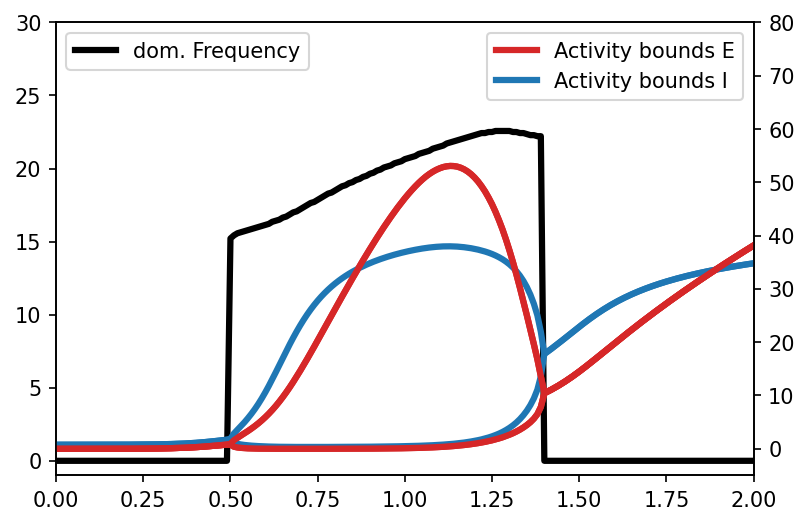

In [9]:
fig, ax = plt.subplots(dpi=150)
ax2=ax.twinx()

df = search.dfResults
ax.plot(df['mue_ext_mean'], df['frequency'], "-", color="black", linewidth=3, label="dom. Frequency")

ax2.plot(df['mue_ext_mean'], df['max_re'], color="tab:red", linewidth=3, label="Activity bounds E")
ax2.plot(df['mue_ext_mean'], df['min_re'], color="tab:red", linewidth=3)
ax2.plot(df['mue_ext_mean'], df['max_ri'], color="tab:blue", linewidth=3, label="Activity bounds I")
ax2.plot(df['mue_ext_mean'], df['min_ri'], color="tab:blue", linewidth=3)
ax2.plot(df['mue_ext_mean'], df['max_re'], color="tab:red", linewidth=3)
ax2.plot(df['mue_ext_mean'], df['min_re'], color="tab:red", linewidth=3)
ax.set_xlim(0, 2.)
ax2.set_ylim(-5, 80)
ax.set_ylim(-1, 30)
ax2.legend()
ax.legend(loc="upper left")

## now with my style

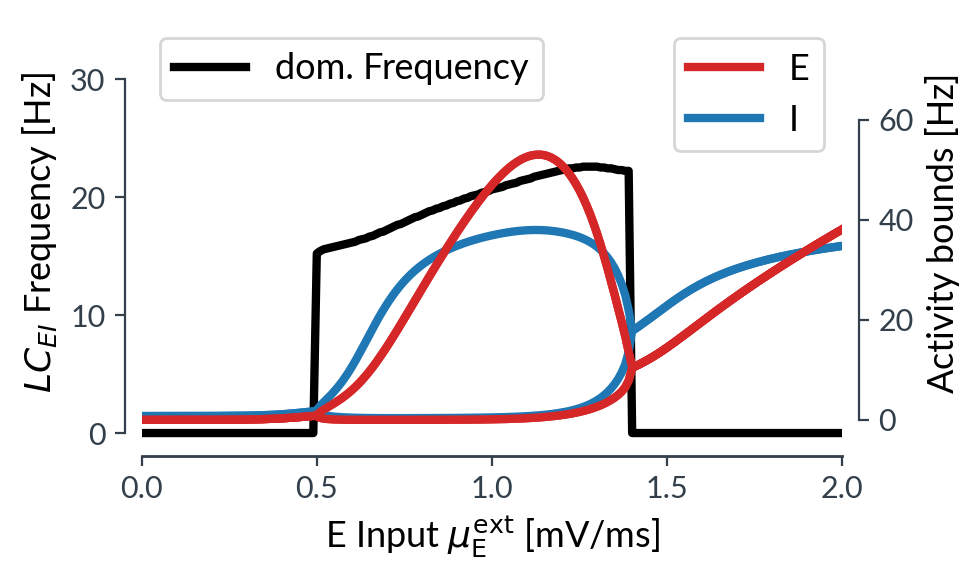

In [10]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
ax2=ax.twinx()

df = search.dfResults
ax.plot(df['mue_ext_mean'], df['frequency'], "-", color="black", linewidth=3, label="dom. Frequency")

ax2.plot(df['mue_ext_mean'], df['max_re'], color="tab:red", linewidth=3, label="E")
ax2.plot(df['mue_ext_mean'], df['min_re'], color="tab:red", linewidth=3)
ax2.plot(df['mue_ext_mean'], df['max_ri'], color="tab:blue", linewidth=3, label="I")
ax2.plot(df['mue_ext_mean'], df['min_ri'], color="tab:blue", linewidth=3)
ax2.plot(df['mue_ext_mean'], df['max_re'], color="tab:red", linewidth=3)
ax2.plot(df['mue_ext_mean'], df['min_re'], color="tab:red", linewidth=3)
ax.set_xlim(0, 2.)
ax2.set_ylim(-5, 80)
ax.set_ylim(-1, 35)
ax2.legend(loc="upper right")
ax.legend(loc="upper left")

ax.set_ylabel("$LC_{EI}$ Frequency [Hz]")
ax.set_xlabel("E Input $\mu^{\mathrm{ext}}_{\mathrm{E}}}}$ [mV/ms]")
ax2.set_ylabel("Activity bounds [Hz]")


ax.tick_params(right=False, top=False)
ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False), ax2.spines["left"].set_visible(False), ax2.spines['bottom'].set_visible(False)

ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(['0', '10', '20','30'])
ax.spines["left"].set_bounds(low=0, high=30)
ax.spines["left"].set_position(("outward", 6))

ax.set_xticks([0.0, 0.5, 1.0, 1.5, 2.0])
ax.set_xticklabels(['0.0','0.5','1.0','1.5','2.0'])


ax2.set_yticks([0, 20, 40, 60])
ax2.set_yticklabels(['0','20','40','60'])
ax2.spines["right"].set_bounds(low=0, high=60)
ax2.spines["right"].set_position(("outward", 6))

#ax.spines["bottom"].set_bounds(low=0, high=2*prc.frperiod)

ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_position(("outward",4))

fig.tight_layout()
fig.savefig("Pics/ALN_Bifurcation_mue_2.pdf")

## II LC Bfurcation 

## II-LC with $\mu_E$ =0

In [11]:
aln = ALNModel()
aln.params['duration'] = 15 * 1000 # in ms
aln.params['dt'] = 0.01
aln.params['sigma_ou'] = 0.
aln.params['de'] = 4.
aln.params['di'] = 9.
aln.params['mue_ext_mean'] = 0.
# no adaptation
aln.params['a'] = 0.
aln.params['b'] = 0. 

MainProcess root INFO     aln: Model initialized.


In [12]:
def mdom_frequency(ts, dt=0.1, SP_WINDOW=100, peak_h=-20):
    ps = func.getPowerSpectrum(ts,
                              dt,
                              maxfr=100,
                              spectrum_windowsize=SP_WINDOW) # powerspectrum 
    peaks, props = find_peaks(ps[1].T, height = peak_h)
    return ps[0][peaks[props['peak_heights'].argmax()]],  max(props['peak_heights']) # dominant frequency of ts 


def evalf(traj):
    pars = search.getParametersFromTraj(traj)
    #aln.params['mue_ext_mean'] = pars['mue_ext_mean']
    aln.params['mui_ext_mean'] = pars['mui_ext_mean']
    aln.run()
    max_re = np.max(aln['rates_exc'][0][ -int(300/aln.params.dt): ])
    min_re = np.min(aln['rates_exc'][0][ -int(300/aln.params.dt): ])
    max_ri = np.max(aln['rates_inh'][0][ -int(300/aln.params.dt): ])
    min_ri = np.min(aln['rates_inh'][0][ -int(300/aln.params.dt): ])
    re = aln['rates_exc'][0][ -int(300/aln.params.dt): ]
    ri = aln['rates_inh'][0][ -int(300/aln.params.dt): ]
    
    try:
        freq, ph  = mdom_frequency(aln['rates_inh'][0][ int(1000/aln.params.dt):  ], 
                             dt=aln.params.dt)
                             
    except: 
        freq = 0.
        ph = np.nan
        
    result_dict = {"frequency" : freq,
                   "ph" : ph, 
                   "max_re" : max_re,
                   "min_re" : min_re, 
                   "max_ri" : max_ri,
                   "min_ri" : min_ri,
                   "re" : re,
                   "ri" : ri}

    search.saveToPypet(result_dict, traj)


In [13]:
mui = np.linspace(0, 2.5, 251)

parameters = ParameterSpace({"mui_ext_mean": mui})
#parameters = ParameterSpace({"mui_ext_mean": [1.]})

search = BoxSearch(evalFunction = evalf,
                   parameterSpace=parameters,
                   #filename=HDF_PATH+'TwoNode_delay_stim_LCmiddle_multistab.hdf')
                    filename=HDF_PATH+'ALN_Bifurcation_to_IILC_1d_mui_mue=0.hdf')

MainProcess root INFO     Number of processes: 4
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/ALN_Bifurcation_to_IILC_1d_mui_mue=0.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 251
MainProcess root INFO     BoxSearch: Environment initialized.


In [14]:
#search.run()

In [15]:
search.loadResults(all=False)

MainProcess root INFO     Loading results from ./data/hdf/../../../../Data/ALN_Bifurcation_to_IILC_1d_mui_mue=0.hdf
MainProcess root INFO     Analyzing trajectory results-2021-10-29-09H-35M-14S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/ALN_Bifurcation_to_IILC_1d_mui_mue=0.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2021-10-29-09H-35M-14S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 251/251 [00:05<00:00, 48.30it/s]
MainProcess root INFO     All results loaded.


In [16]:
for i in search.dfResults.index:
    search.dfResults.loc[i, 'ph_log'] = np.log(search.dfResults['ph'][i])

In [17]:
for i in search.dfResults.index:
    if search.dfResults['ph_log'][i] > -11:
        search.dfResults.loc[i, 'state'] = 1
        search.dfResults.loc[i, 'frequency2'] = search.dfResults['frequency'][i]
    else:
        search.dfResults.loc[i, 'state'] = 0
        search.dfResults.loc[i, 'frequency2'] = 0
        
    if search.dfResults['mui_ext_mean'][i] < 0.0:
        search.dfResults.loc[i, 'maxe2'] = 0.
        search.dfResults.loc[i, 'mine2'] = 0.
        search.dfResults.loc[i, 'maxi2'] = 0.
        search.dfResults.loc[i, 'mini2'] = 0.
    else:
        search.dfResults.loc[i, 'maxe2'] = search.dfResults['max_re'][i]
        search.dfResults.loc[i, 'mine2'] = search.dfResults['min_re'][i]
        search.dfResults.loc[i, 'maxi2'] = search.dfResults['max_ri'][i]
        search.dfResults.loc[i, 'mini2'] = search.dfResults['min_ri'][i]

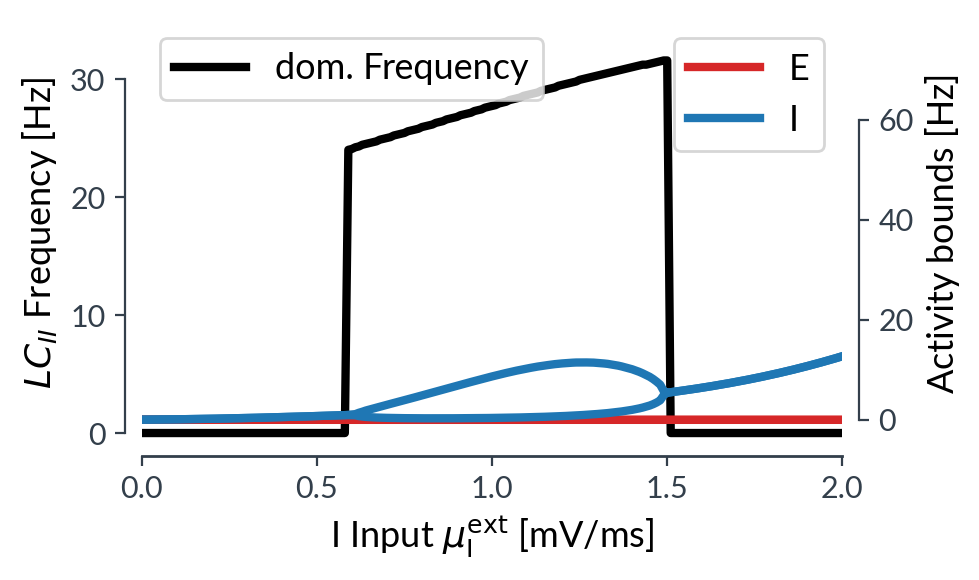

In [18]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
ax2=ax.twinx()

df = search.dfResults
ax.plot(df['mui_ext_mean'], df['frequency2'], "-", color="black", linewidth=3, label="dom. Frequency")

ax2.plot(df['mui_ext_mean'], df['maxe2'], color="tab:red", linewidth=3, label="E")
ax2.plot(df['mui_ext_mean'], df['mine2'], color="tab:red", linewidth=3)
ax2.plot(df['mui_ext_mean'], df['maxi2'], color="tab:blue", linewidth=3, label="I")
ax2.plot(df['mui_ext_mean'], df['mini2'], color="tab:blue", linewidth=3)

ax.set_xlim(0., 2.)
ax2.set_ylim(-5, 80)
ax.set_ylim(-1, 35)
ax2.legend(loc="upper right")
ax.legend(loc="upper left")

ax.set_ylabel("$LC_{II}$ Frequency [Hz]")
ax.set_xlabel("I Input $\mu^{\mathrm{ext}}_{\mathrm{I}}}}$ [mV/ms]")
ax2.set_ylabel("Activity bounds [Hz]")


ax.tick_params(right=False, top=False)
ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False), ax2.spines["left"].set_visible(False), ax2.spines['bottom'].set_visible(False)

ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(['0', '10', '20','30'])
ax.spines["left"].set_bounds(low=0, high=30)
ax.spines["left"].set_position(("outward", 6))

#ax.set_xticks([0.0, 0.5, 1.0, 1.5, 2.0])
#ax.set_xticklabels(['0.0','0.5','1.0','1.5','2.0'])



ax2.set_yticks([0, 20, 40, 60])
ax2.set_yticklabels(['0','20','40','60'])
ax2.spines["right"].set_bounds(low=0, high=60)
ax2.spines["right"].set_position(("outward", 6))

#ax.spines["bottom"].set_bounds(low=0, high=2*prc.frperiod)

ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_position(("outward",4))

fig.tight_layout()
fig.savefig("Pics/ALN_Bifurcation_II_mui_2.pdf")